In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import eurec4a
import dask

In [2]:
cat = eurec4a.get_intake_catalog()

# Do we find c3ontext?
print(list(cat.c3ontext))

ds = cat.c3ontext.level3_IR_instant.to_dask() # This doesn't work on Anunna, don't know why... Also times out sometimes
ds
# So using downloaded data instead
# ds = xr.open_zarr('processed_data/EUREC4A_ManualClassifications_l3_IR_instant.zarr')
# ds
# Time interval is every two hours (you have every 30 min)

['level2', 'level3_ICON-albedo_instant', 'level3_ICON-albedo_daily', 'level3_IR_instant', 'level3_IR_daily', 'level3_VIS_instant', 'level3_VIS_daily']


<xarray.Dataset>
Dimensions:    (date: 564, longitude: 2200, latitude: 1500, pattern: 5)
Coordinates:
  * date       (date) datetime64[ns] 2020-01-07 ... 2020-02-22T22:00:00
  * latitude   (latitude) float64 20.0 19.99 19.98 19.97 ... 5.03 5.02 5.01 5.0
  * longitude  (longitude) float64 -62.0 -61.99 -61.98 ... -40.02 -40.01 -40.0
  * pattern    (pattern) object 'Sugar' 'Flowers' 'Fish' 'Gravel' 'Unclassified'
Data variables:
    freq       (date, longitude, latitude, pattern) float64 dask.array<chunksize=(1, 2200, 1500, 5), meta=np.ndarray>
    nb_users   (date) float64 dask.array<chunksize=(564,), meta=np.ndarray>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2022-02-06 08:32 UTC
    created_with:    create_level3.py with its last modification on Sun Feb  ...
    description:     Level-3: instant classification frequency
    doi:             10.5281/zenodo.5979718
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.8.6 | packaged by conda-forge | (default, Nov 27 2020,...
    title:           EUREC4A: manual meso-scale cloud pattern classifications
    version:         v0.4.0

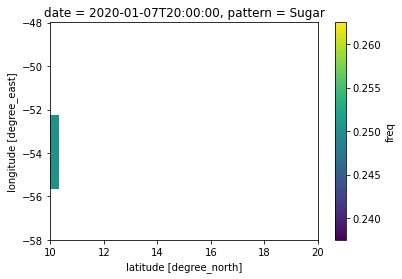

In [3]:
lat0, lat1, lon0, lon1 = [10, 20, -58, -47.99] # See cloudmetrics-goes16-IR.ipynb

test_scene = ds.freq.isel(date=10).sel(latitude=slice(lat1, lat0), longitude=slice(lon0,lon1))
test_scene.sel(pattern='Sugar').plot()

In [4]:
# What is coverage fraction for each pattern in this scene?
freq_threshold = 0.1 # Hauke says it's a pattern if 10% of participants agree

for pat in ds.pattern:
    freq = test_scene.sel(pattern=pat).values
    
    frac = (np.count_nonzero(freq[np.isreal(freq)] > freq_threshold)
            / (test_scene.latitude.size * test_scene.longitude.size))

    print(pat.values, ":", frac)

Sugar : 0.011514485514485515
Flowers : 0.0
Fish : 0.352
Gravel : 0.40557542457542456
Unclassified : 1.0


But what do you do if these add up to more than 1? Just accept a patch can be in multiple classes at the same time?

In [5]:
# Compute coverage fraction for each scene, following
# https://github.com/observingClouds/C3ONTEXT/blob/fa2740aac9a7b1e7287b32651db9737f93ee4c57/scripts/calculate_agreement.py

load_df = True

if load_df:
    df_sgff = pd.read_hdf('df_sgff.h5')
else:
    df_sgff = pd.DataFrame(index=ds['date'], columns=ds['pattern'].values)
    for i in range(len(ds['date'])):
        print('Processing ', ds['date'][i].data, 'scene ', i+1, '/', len(ds['date']))

        scene = ds.freq.isel(date=i).sel(latitude=slice(lat1, lat0), longitude=slice(lon0,lon1))

        for pat in ds.pattern:
            freq = scene.sel(pattern=pat).values

            frac = (np.count_nonzero(freq[np.isreal(freq)] > freq_threshold)
                    / (scene.latitude.size * scene.longitude.size))

            print(pat.values, ":", frac)
            df_sgff.iloc[i].loc[str(pat.values)] = frac
        df_sgff.to_hdf('df_sgff.h5', 'sgff', mode='w')
df_sgff

,Sugar,Flowers,Fish,Gravel,Unclassified
2020-01-07 00:00:00,0.0,0.0,0.0,0.0,0.0
2020-01-07 02:00:00,0.122542,0.0,0.0,0.336788,1.0
2020-01-07 04:00:00,0.04515,0.0,0.480847,0.71187,1.0
2020-01-07 06:00:00,0.0,0.0,0.0,0.116768,1.0
2020-01-07 08:00:00,0.0,0.804581,0.0,0.461145,1.0
...,...,...,...,...,...
2020-02-22 14:00:00,0.139175,0.328364,0.204725,0.432915,1.0
2020-02-22 16:00:00,0.25984,0.0,0.143473,0.518182,1.0
2020-02-22 18:00:00,0.0,0.0,0.0,0.776501,1.0
2020-02-22 20:00:00,0.371014,0.0,0.0,0.500798,1.0


In [6]:
# Get daily mean coverage fraction

df_sgff.index.rename('date', inplace=True)
ds_sgff = df_sgff.to_xarray()

# FIXME xarray cannot do this on all data variables at the same time for reasons that remain unclear -> Loop instead
def ds_date_mean(ds):
    keys = [i for i in ds.data_vars]
    for i in range(len(keys)):
        if i == 0:
            ds_date = ds[keys[i]].groupby('date.date').mean()
        else:
            ds_date = xr.merge([ds_date, ds[keys[i]].groupby('date.date').mean()])
    return ds_date

ds_sgff_date = ds_date_mean(ds_sgff)
ds_sgff_date

<xarray.Dataset>
Dimensions:       (date: 47)
Coordinates:
  * date          (date) object 2020-01-07 2020-01-08 ... 2020-02-21 2020-02-22
Data variables:
    Sugar         (date) float64 0.03436 0.2112 0.1044 ... 0.08972 0.2032
    Flowers       (date) float64 0.2537 0.4031 0.478 ... 0.678 0.2122 0.02736
    Fish          (date) float64 0.1112 0.007615 0.2291 ... 0.07972 0.0959
    Gravel        (date) float64 0.2081 0.323 0.5865 ... 0.08539 0.183 0.3583
    Unclassified  (date) float64 0.9167 1.0 0.9339 0.9398 ... 1.0 1.0 1.0 1.0

In [7]:
# Get daily mean location in pattern space (from cloudmetrics-c3ontext notebook)

from Postprocess import analysis, utils
from sklearn.decomposition import PCA

metrics = ['cloud_fraction',
           'fractal_dimension',
           'open_sky',
           'cop',
           'iorg',
           'scai',
           'max_length_scale',
           'mean_eccentricity',
           'mean_length_scale',
           'mean_perimeter_length',
           'num_objects',
           'orientation',
           'spectral_length_moment',
           'spectral_anisotropy',
           'spectral_slope',
           'woi1',
           'woi2',
           'woi3',
           'mean',
           'var'
          ]

# Read from file
df_metrics_pp = pd.read_hdf('df_metrics.h5')

# Filter scenes which miss metrics
nan_filter = metrics
for ind in nan_filter:
    df_metrics_pp = df_metrics_pp[df_metrics_pp[ind].notna()]
# print(df_metrics_pp.isna().any())

# Standardise metrics
data = df_metrics_pp.to_numpy()
data = utils.stand(data)
    
# Compute PCA
pca = PCA()
x_pca = pca.fit_transform(data)

# Rotate so PC3/PC4 align a little better with woi3 and var (this should be used purely for visualisation)
angle = 20*np.pi/180
rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                   [np.sin(angle),  np.cos(angle)]])
x_pca[:,[2,3]] = np.dot(x_pca[:,[2,3]],rot_mat) 

# Stick in df -> ds -> normalise each axis -> subset by date
df_pca = pd.DataFrame(index=df_metrics_pp.index, data=x_pca)
df_pca.index.rename('date', inplace=True)
df_pca = df_pca/df_pca.std()

ds_pca = df_pca.to_xarray()
ds_pca_date = ds_date_mean(ds_pca)
ds_pca_date

<xarray.Dataset>
Dimensions:  (date: 60)
Coordinates:
  * date     (date) object 2020-01-01 2020-01-02 ... 2020-02-28 2020-02-29
Data variables: (12/20)
    0        (date) float64 0.4521 0.0299 0.2103 ... -0.3739 -0.07722 -0.1124
    1        (date) float64 0.7723 0.9703 1.292 0.5083 ... 0.5343 0.6672 0.06253
    2        (date) float64 0.1736 0.5145 -0.08382 ... 0.06069 -0.06537 2.304
    3        (date) float64 -0.579 -0.1082 -0.1102 ... -0.345 -0.5449 -0.2548
    4        (date) float64 1.372 1.827 0.2006 ... -0.3907 -0.03464 -0.6502
    5        (date) float64 -0.1518 -0.01076 0.4551 ... -0.6255 0.1507 0.3736
    ...       ...
    14       (date) float64 0.3863 0.1046 0.1383 ... 0.02702 0.2252 0.4019
    15       (date) float64 -0.05726 -0.217 -1.711 ... -0.08551 -0.3961 -0.5071
    16       (date) float64 0.4196 0.307 0.7406 0.2332 ... -0.5262 -0.199 0.4238
    17       (date) float64 -0.3786 -0.8011 -0.2723 ... -0.6265 0.4138 0.2243
    18       (date) float64 -0.2938 -0.5238 -0.4935 ... 0.4904 -0.3865 -0.3526
    19       (date) float64 -0.2315 -0.2283 0.374 ... -0.05721 -0.9214 -1.174

In [8]:
from matplotlib.patches import Wedge
import seaborn as sns

In [9]:
# Make similar plot as in Hauke's paper, using pcs, following 
# https://github.com/observingClouds/C3ONTEXT/blob/master/notebooks/fig6_fig7_agreement_classifications.ipynb

pat_list = ['Sugar','Gravel', 'Flowers','Fish']
color_dict = {'Sugar':'#A1D791',
              'Fish':'#2281BB',
              'Gravel':'#3EAE47',
              'Flowers': '#93D2E2',
              'Unclassified': 'lightgrey'}

def plot_wedges_sgff(ds_pca, selvars, ds_sgff, ax=None, xlab=None, ylab=None, legend=False):

    if ax == None:
        fig, ax = plt.subplots(figsize=(5,5))

    ax.plot(ds_pca[selvars[0]], ds_pca[selvars[1]],'.', markersize=1)

    for t in range(ds_pca.date.size):

        # Extract date
        date = ds_pca.isel(date=t).date.values
        try:
            data = ds_sgff.sel(date=date)
        except KeyError:
#             print('Didnt find ', date)
            continue

        # Coordinates in pc space
        x = ds_pca[selvars[0]].isel(date=t).values
        y = ds_pca[selvars[1]].isel(date=t).values

        # Wedge loop
        for p_,pattern in enumerate(pat_list):
            w = Wedge((x, y), data[pattern].values*0.45, p_*90, (p_+1)*90, fc=color_dict[pattern])
            ax.add_patch(w)

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    # ax.set_xlim()
    # ax.set_ylim()
        
    # Legend wedge
    if legend:
        
        pos = ax.get_position()
        legax = fig.add_axes([1., pos.ymin, 0.5, 0.5])
        legax.axis('off')
        
        x_leg = 0.2
        y_leg = 0.6
        dx = 0.15
        dy = 0.15
        d_wedge = 0.14
        for p_,pattern in enumerate(pat_list):
            w = Wedge((x_leg, y_leg), d_wedge, p_*90, (p_+1)*90, fc=color_dict[pattern])
            legax.add_patch(w)
        legax.annotate(pat_list[0], (x_leg+dx,y_leg+dy), ha='center', va='center')
        legax.annotate(pat_list[1], (x_leg-dx,y_leg+dy), ha='center', va='center')
        legax.annotate(pat_list[2], (x_leg-dx,y_leg-dy), ha='center', va='center')
        legax.annotate(pat_list[3], (x_leg+dx,y_leg-dy), ha='center', va='center')
        
        legax.annotate('Scene coverage fraction:',(x_leg, y_leg-1.75*dy),ha='center', va='center')        
        w = Wedge((x_leg, y_leg-2.25*dy), d_wedge, p_*90, (p_+1)*90, fc='k')
        legax.add_patch(w)
        legax.annotate('1.0',(x_leg-dx, y_leg-2.5*dy),ha='center', va='center')
        
        w = Wedge((x_leg, y_leg-3.5*dy), d_wedge*0.3, p_*90, (p_+1)*90, fc='k')
        legax.add_patch(w)
        legax.annotate('0.3',(x_leg-dx, y_leg-3.75*dy),ha='center', va='center')
        
    sns.despine(offset=5)
    return ax

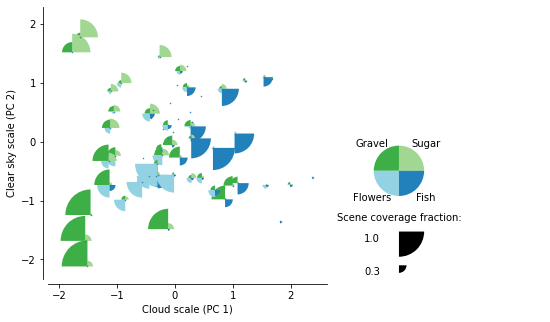

In [10]:
pcs = [0,1]
ax = plot_wedges_sgff(ds_pca_date[pcs],
                      pcs,
                      ds_sgff_date, 
                      xlab='Cloud scale (PC 1)',
                      ylab='Clear sky scale (PC 2)',
                      legend=True)
plt.savefig('Figures/cloudmetrics-sgff-pc12.pdf', bbox_inches='tight')

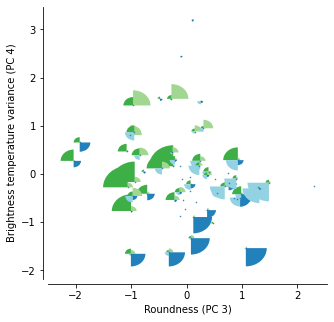

In [11]:
pcs = [2,3]
ax = plot_wedges_sgff(ds_pca_date[pcs],
                      pcs,
                      ds_sgff_date, 
                      xlab='Roundness (PC 3)',
                      ylab='Brightness temperature variance (PC 4)',
                      legend=False)
plt.savefig('Figures/cloudmetrics-sgff-pc34.pdf', bbox_inches='tight')

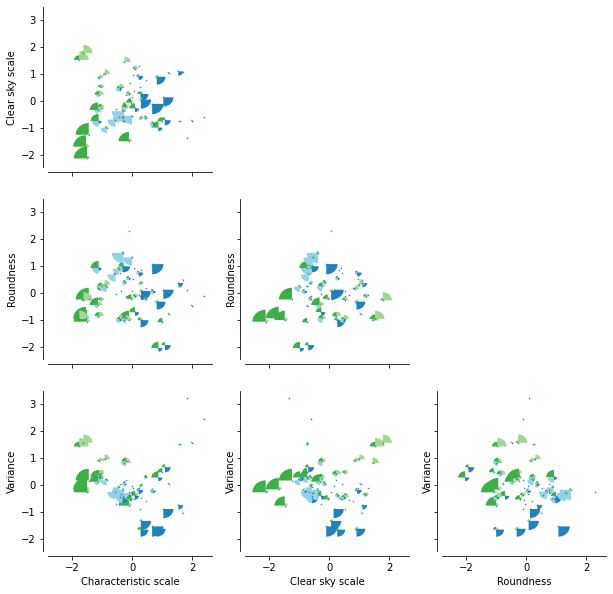

In [12]:
fig, axs = plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(10,10))

labs = ['Characteristic scale', 'Clear sky scale', 'Roundness', 'Variance']

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if j <= i:
            xlab = labs[j] if i == len(labs)-2 else None
            ylab = labs[i+1] if j == 0 else None
            pcs = [j,i+1]
            plot_wedges_sgff(ds_pca_date[pcs], pcs, ds_sgff_date, ax=axs[i,j], xlab=xlab, ylab=labs[i+1])
        else:
            fig.delaxes(axs[i,j])
plt.savefig('Figures/cloudmetrics-c3ontext.pdf', bbox_inches='tight')

People tend to find
- 'Sugar' in scenes characeterised by large, clear-sky swaths (and low cloud fractions), intermediate to small cloud sizes and rather large variance in brightness temperature
- 'Gravel' in unclustered scenes characterised by small, clear-sky regions, small clouds and little directional preference
- 'Fish' simply as the largest structures they see. Curiously, they are also the structures that exhibit the smallest amount of brightness temperature variance over a scene?
- 'Flowers' as intermediate-sized structures with relatively little clear-sky spacing between them, and *no directional alignment*.

My (shallow) interpretation:
- We actually seem to need 3 PCs to separate the classes from each other sucessfully (2 are insufficient to distinguish Flowers).
- Agreement on a pattern class relates rather clearly to extremes in the metric distribution, i.e. they really are not typical in any statistical sense, but manifestations of variability

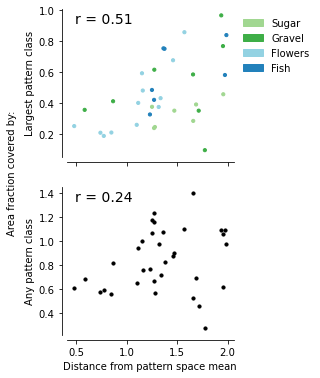

In [13]:
# Quantify coverage fraction as a function of distance from centroid of the hyperblob
from scipy.stats import pearsonr
import matplotlib.patches as mpatches


pcs = [0,1,2,3]
df_sgff_date_d = ds_sgff_date.to_dataframe()
df_pca_date_d = ds_pca_date[pcs].to_dataframe()

# Add cartesian distance d from mean of metric space as column to ds_sgff_date
df_sgff_date_d['Distance'] = np.sqrt((df_pca_date_d**2).sum(axis=1)) # axis=1 indicates operations over columns

# Also add as columns to df_sgff_date_d the area fraction of the most dominant pattern (MaxPattern),
# the corresponding column index (ArgMaxPattern), and the total area fraction covered by any of the
# four pattern classes (AnyPattern)
df_sgff_date_d['MaxPattern'] = df_sgff_date_d[['Sugar','Gravel','Fish','Flowers']].max(axis=1)
df_sgff_date_d['ArgMaxPattern'] = df_sgff_date_d[['Sugar','Gravel','Fish','Flowers']].idxmax(axis=1)
df_sgff_date_d['AnyPattern'] = df_sgff_date_d[['Sugar','Gravel','Fish','Flowers']].sum(axis=1)

# Filter very large distances not to clutter plots (basically considered outliers here, don't know if that's reasonable)
df_sgff_date_d = df_sgff_date_d[df_sgff_date_d.Distance < 2]

# Simple pearson correlation
r_dpm = pearsonr(df_sgff_date_d['Distance'],df_sgff_date_d['MaxPattern'])[0]
r_dps = pearsonr(df_sgff_date_d['Distance'],df_sgff_date_d['AnyPattern'])[0]

# Colors
colors = []
for i in range(df_sgff_date_d.shape[0]):
    colors.append(color_dict[df_sgff_date_d['ArgMaxPattern'].iloc[i]])

# Make figure
fig,axs = plt.subplots(ncols=1, nrows=2, figsize=(3,6), sharex=True)
fig.text(-0.15, 0.5, 'Area fraction covered by:', va='center', rotation='vertical')

# Area fraction of dominant pattern class (y) as a function of distance from pattern mean (x)
axs[0].scatter(df_sgff_date_d['Distance'],df_sgff_date_d['MaxPattern'],c=colors,s=10)
axs[0].annotate('r = %.2f'%r_dpm, (0.05,0.9), xycoords='axes fraction', fontsize=14)
axs[0].set_ylabel('Largest pattern class')

patches = [mpatches.Patch(color=color_dict['Sugar'], label='Sugar'),
           mpatches.Patch(color=color_dict['Gravel'], label='Gravel'),
           mpatches.Patch(color=color_dict['Flowers'], label='Flowers'),
           mpatches.Patch(color=color_dict['Fish'], label='Fish')
          ]
axs[0].legend(handles=patches, bbox_to_anchor=(1,1), loc='best', frameon=False)

# Total area fraction covered by sugar, gravel, fish and flowers (y) as a function of distance from pattern mean (x)
axs[1].scatter(df_sgff_date_d['Distance'],df_sgff_date_d['AnyPattern'],c='k',s=10)
axs[1].annotate('r = %.2f'%r_dps, (0.05,0.9), xycoords='axes fraction', fontsize=14)
axs[1].set_ylabel('Any pattern class')
axs[1].set_xlabel('Distance from pattern space mean')

sns.despine(offset=5)

plt.savefig('Figures/extremeness-sgff.pdf',bbox_inches='tight')

Regarding the extremeness of the identified patterns, it seems like Hauke and I both have a point:
1. If you purely look at how the coverage fraction of the dominant pattern class in a scene changes with distance from the mean of the pattern space (top figure), it is a robustly increasing function (r=0.51, **todo: still need to bootstrap for better estimate on sampling error here**)
2. But if you look at how the sum of the area fractions of the pattern classes changes with distance from the mean (bottom figure), the correlation does drop (r=0.24), i.e. you do still find subsets of different patterns co-existing together in scenes near the pattern mean, which therefore don't end up near an extreme of the metric distribution. Nevertheless, the positive correlation remains there, especially for scenes that aren't too far from the centre (i.e. close to the "typical situation")

Should still interpret these results with care, because:
- There are scenes far from the mean of the pattern space that aren't SGFF, i.e. SGFF aren't the only extreme patterns (but what are they?)
- The current agreement fraction before labelling something a particular pattern (10%) seems quite low and frequently leads to summed fractions of SGFF that exceed 1. I imagine the results might be quite sensitive to this.
